<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/PINNs/blob/main/pinn_para_edp_acoplada_condi%C3%A7%C3%A3o_Mistaverro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
!pip install pyDOE

In [55]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras import Sequential
from keras.layers import Input, Dense
from time import time
from keras.optimizers import Adam
from keras.initializers import Ones, GlorotNormal, he_normal, Zeros
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from pyDOE import lhs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.optimize
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import display, Image, HTML

In [56]:
keras.backend.set_floatx('float32')
tf.random.set_seed(0)
k = 1

In [57]:
#Definindo os pontos X
N_0 = 200 #300 pontos para condição inicial
N_bx = 200 #300 pontos para condição de contorno em x
N_by = 200 #300 pontos para a condição de contorno em y
N_r = 20000 #Pontos para a edp

#Pontos do domínio
tmin = 0. ; tmax = 1.
xmin = 0.; xmax = 1.
ymin = 0.; ymax = 1.

#Ponto inferior e superior, respectivamente
lb = tf.constant([tmin, xmin, ymin]); ub = tf.constant([tmax, xmax, ymax])

In [58]:
#Agora criando o modelo de Rede neural

def modelopinn(nos, camadas_ocultas):
  modelo = Sequential()
  #Inserindo o numero de variaveis de entrada
  modelo.add(Input(3))
  #Escala de entrada, mapeando os pontos de maximo e minimo

  modelo.add(keras.layers.Lambda(
      lambda x: 2.0*(x - lb)/(ub - lb) - 1.0
  ))
  for i in range(camadas_ocultas):
        modelo.add(Dense(nos, activation='tanh', kernel_initializer=GlorotNormal())) #camada oculta

  modelo.add(Dense(2)) #camada de saída
  modelo.summary()
  return modelo

In [59]:
modelo = modelopinn(30,10)

otimizador = Adam(learning_rate = 0.001)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 3)                 0         
                                                                 
 dense_40 (Dense)            (None, 30)                120       
                                                                 
 dense_41 (Dense)            (None, 30)                930       
                                                                 
 dense_42 (Dense)            (None, 30)                930       
                                                                 
 dense_43 (Dense)            (None, 30)                930       
                                                                 
 dense_44 (Dense)            (None, 30)                930       
                                                                 
 dense_45 (Dense)            (None, 30)               

In [60]:
def c_contorno(t, x, y):
  n = x.shape[0]
  return tf.where(tf.equal(x, 0), tf.ones((n, 1)), tf.zeros((n, 1)))

def p_contorno(t, x, y):
  n = x.shape[0]
  return tf.where(tf.equal(x, 0), tf.ones((n, 1)), tf.zeros((n, 1)))

def c_inicial(x, y):
  return tf.zeros_like(x)

In [61]:
#pontos de contorno, inicial
t0 = tf.zeros((N_0,1))*lb[0]
x0 = tf.random.uniform((N_0,1), lb[1], ub[1]) #Colocando os valores de x0 em ordem aleatoria, indo de 0 a 1
y0 = tf.random.uniform((N_0, 1), lb[2], ub[2])
espaco0 = tf.concat([t0, x0, y0], 1)
c0 = c_inicial(x0,y0)

tbx1 = tf.random.uniform((N_by,1), lb[0], ub[0])
xbx1 = tf.zeros((N_bx,1))
ybx1 = tf.random.uniform((N_by,1), lb[2], ub[2])
espacobx1 = tf.concat([tbx1, xbx1, ybx1], 1)
c_contx1 = c_contorno(tbx1, xbx1, ybx1)
p_contx1 = p_contorno(tbx1, xbx1, ybx1)

tbx2 = tf.random.uniform((N_by,1), lb[0], ub[0])
xbx2 = tf.ones((N_bx,1))
ybx2 = tf.random.uniform((N_by,1), lb[2], ub[2])
espacobx2 = tf.concat([tbx2, xbx2, ybx2], 1)
p_contx2 = p_contorno(tbx2, xbx2, ybx2)

tby1 = tf.random.uniform((N_by,1), lb[0], ub[0])
xby1 = tf.random.uniform((N_by,1), lb[2], ub[2])
yby1 = tf.zeros((N_bx,1))
espacoby1 = tf.concat([tby1, xby1, yby1], 1)

tby2 = tf.random.uniform((N_by,1), lb[0], ub[0])
xby2 = tf.random.uniform((N_by,1), lb[2], ub[2])
yby2 = tf.ones((N_bx,1))
espacoby2 = tf.concat([tby2, xby2, yby2], 1)

#Repetindo o processo, mas agora é para obter os pontos da EDP
tr = tf.random.uniform((N_r,1), lb[0], ub[0])
xr = tf.random.uniform((N_r,1), lb[1], ub[1])
yr = tf.random.uniform((N_r,1), lb[2], ub[2])
espacor = tf.concat([tr, xr,yr], 1)

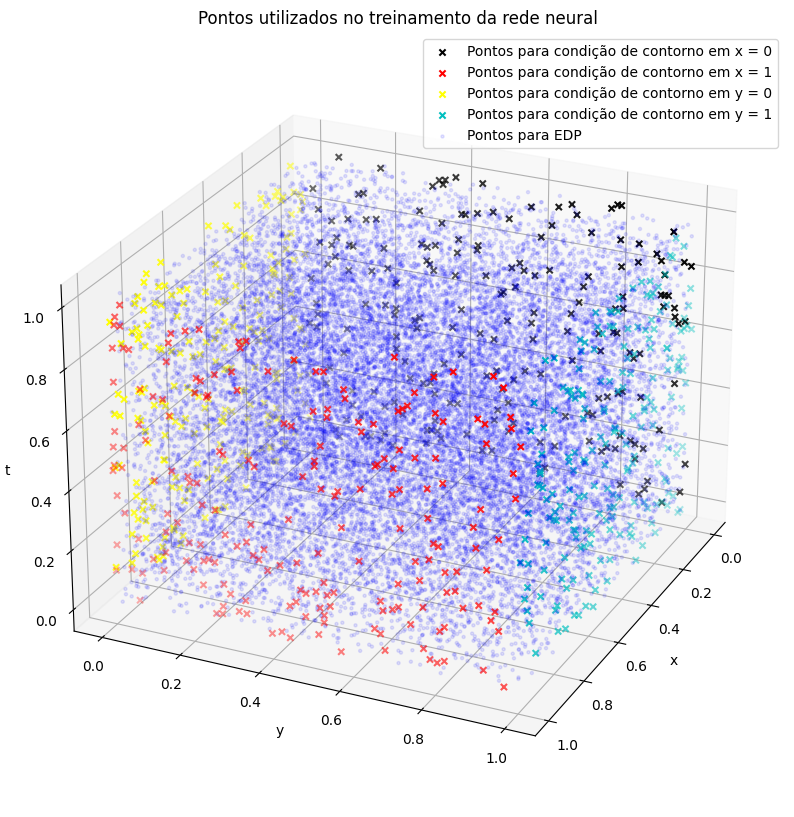

In [62]:
# Plotar os pontos que serão utilizados
fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xbx1,ybx1,tbx1, c = 'black', marker ='x', label = 'Pontos para condição de contorno em x = 0')
ax.scatter(xbx2,ybx2,tbx2, c = 'red', marker = 'x', label = 'Pontos para condição de contorno em x = 1')
ax.scatter(xby1,yby1,tby1, c = 'yellow', marker = 'x', label = 'Pontos para condição de contorno em y = 0')
ax.scatter(xby2,yby2,tby2, c = 'c', marker = 'x', label = 'Pontos para condição de contorno em y = 1')
ax.scatter(xr,yr,tr, c = 'blue', marker = '.', alpha = 0.1, label = 'Pontos para EDP')
ax.view_init(25,25)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
ax.legend()
ax.set_title('Pontos utilizados no treinamento da rede neural');
plt.show()

In [63]:
#E tirando os gradientes, para calcular a edp
def gradiente(modelo, X_r):
  with tf.GradientTape(persistent=True) as tape:

    #Registrando tempo e posição para a diferenciação automática
    t, x, y = X_r[:, 0:1], X_r[:,1:2], X_r[:,2:3]
    tape.watch(t)
    tape.watch(x)
    tape.watch(y)

    #previsão do modelo
    u = modelo(tf.concat([t, x, y], axis = 1))
    p, c = u[:, 0:1], u[:, 1:2]
    #gradiente du/dx
    f = -( tape.gradient(tape.gradient(p, x), x) + tape.gradient(tape.gradient(p, y), y))
    #gradiente du/dy
    v1 = -tape.gradient(p,x)
    v2 = -tape.gradient(p,y)
    g = tape.gradient(c,t) + tape.gradient(v1*c, x) + tape.gradient(v2*c , y)
    c_x = tape.gradient(c, x)
    c_y = tape.gradient(c, y)
    p_y = tape.gradient(p, y)

  del tape

  return f, g, c_x, c_y, p_y

def neumanncondx2(modelo, espacobx2, p_contx2):
  with tf.GradientTape(persistent=True) as tape:

    #Registrando tempo e posição para a diferenciação automática
    tx2, xx2, yx2 = espacobx2[:, 0:1], espacobx2[:,1:2], espacobx2[:,2:3]
    tape.watch(tx2)
    tape.watch(xx2)
    tape.watch(yx2)
    #previsão do modelo
    u = modelo(tf.concat([tx2, xx2, yx2], axis = 1))
    p, c = u[:, 0:1], u[:, 1:2]
    c_x = tape.gradient(c, xx2)

    return p, c_x


def neumanncondy2(modelo, espacoby2):
  with tf.GradientTape(persistent=True) as tape:

    #Registrando tempo e posição para a diferenciação automática
    ty2, xy2, yy2 = espacoby2[:, 0:1], espacoby2[:,1:2], espacoby2[:,2:3]
    tape.watch(ty2)
    tape.watch(xy2)
    tape.watch(yy2)
    #previsão do modelo
    u = modelo(tf.concat([ty2, xy2, yy2], axis = 1))
    p, c = u[:, 0:1], u[:, 1:2]
    p_y = tape.gradient(p, yy2)
    c_y = tape.gradient(c, yy2)

    return p_y, c_y

def neumanncondy1(modelo, espacoby1):
  with tf.GradientTape(persistent=True) as tape:

    #Registrando tempo e posição para a diferenciação automática
    ty1, xy1, yy1 = espacoby1[:, 0:1], espacoby1[:,1:2], espacoby1[:,2:3]
    tape.watch(ty1)
    tape.watch(xy1)
    tape.watch(yy1)
    #previsão do modelo
    u = modelo(tf.concat([ty1, xy1, yy1], axis = 1))
    p, c = u[:, 0:1], u[:, 1:2]
    p_y = tape.gradient(p, yy1)
    c_y = tape.gradient(c, yy1)

    return p_y, c_y

def MSE(modelo, xr, espaco0, c0, espacobx1, p_contx1, c_contx1, espacobx2, p_contx2, espacoby1, espacoby2):

    #Erro edp
    f, g, c_x, c_y, p_y = gradiente(modelo, xr)
    erro_p = tf.reduce_mean(tf.square(f))
    erro_c = tf.reduce_mean(tf.square(g))

    loss = erro_p + erro_c
    with tf.GradientTape(persistent=True) as tape:
      #Registrando tempo e posição para a diferenciação automática
      tx1, xx1, yx1 = espacobx1[:, 0:1], espacobx1[:,1:2], espacobx1[:,2:3]
      tape.watch(tx1)
      tape.watch(xx1)
      tape.watch(yx1)
      #previsão do modelo
      u = modelo(tf.concat([tx1, xx1, yx1], axis = 1))
      px1, cx1 = u[:, 0:1], u[:, 1:2]
    u0 = modelo(espaco0)
    p0pred, c0pred = u0[:, 0:1], u0[:, 1:2]

    p_pred, c_x = neumanncondx2(modelo, espacobx2, p_contx2)
    p_y1, c_y = neumanncondy1(modelo, espacoby1)
    p_y2, c_y2 = neumanncondy2(modelo, espacoby2)

    loss += tf.reduce_mean(tf.square(p_contx2 - p_pred))
    loss += tf.reduce_mean(tf.square(c_x))
    loss += tf.reduce_mean(tf.square(p_y1))
    loss += tf.reduce_mean(tf.square(c_y))
    loss += tf.reduce_mean(tf.square(p_y2))
    loss += tf.reduce_mean(tf.square(c_y2))
    loss += tf.reduce_mean(tf.square(p_contx1 - px1))
    loss += tf.reduce_mean(tf.square(c_contx1 - cx1))
    loss += tf.reduce_mean(tf.square(c0 - c0pred))

    return erro_p, erro_c, loss

def grad(modelo, xr, espaco0, c0, espacobx1, p_contx1, c_contx1, espacobx2, p_contx2, espacoby1, espacoby2):
  #tirando o gradiente em relação ao modelos, para que eles sejam atualizados posteriormente
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(modelo.trainable_variables)
    erro_p, erro_c, loss = MSE(modelo, xr, espaco0, c0, espacobx1, p_contx1, c_contx1, espacobx2, p_contx2, espacoby1, espacoby2)

  g = tape.gradient(loss, modelo.trainable_variables)
  del tape

  return erro_p, erro_c, loss, g

In [64]:
#etapa de treinamento como uma função do TensorFlow para aumentar a velocidade do treinamento
@tf.function
def train_step(modelo):
  #Calculando a perda do modelo em relação ao modelo, com a função grad
  erro_p, erro_c, loss, grad_theta = grad(modelo, espacor, espaco0, c0, espacobx1, p_contx1, c_contx1, espacobx2, p_contx2, espacoby1, espacoby2)

  #Aplicando o gradiente as variaveis do modelo de rede neural
  otimizador.apply_gradients(zip(grad_theta, modelo.trainable_variables))

  return erro_p, erro_c, loss

itr = 2000
historico = []
erro_aux_p = []
erro_aux_c = []
t0 = time()

for i in range(itr+1):

    erro_p, erro_c, loss = train_step(modelo)

    #Salvando os erros para listar
    historico.append(loss.numpy())
    erro_aux_p.append(erro_p.numpy())
    erro_aux_c.append(erro_c.numpy())


    if i%100 == 0:
        print(i,"Loss treino: {:10.8e}, Loss edp f: {:10.8e}, Loss edp g: {:10.8e}".format(loss, erro_p, erro_c))

print('\nTempo de treino da rede neural: {} segundos'.format(time()-t0))

0 Loss treino: 1.06242256e+01, Loss edp f: 3.18154883e+00, Loss edp g: 3.86418128e+00
100 Loss treino: 2.49228716e-01, Loss edp f: 3.20230536e-02, Loss edp g: 3.35717760e-02
200 Loss treino: 1.63692966e-01, Loss edp f: 8.85097962e-03, Loss edp g: 2.32289247e-02
300 Loss treino: 1.33728862e-01, Loss edp f: 7.86955375e-03, Loss edp g: 1.74592827e-02
400 Loss treino: 1.06934011e-01, Loss edp f: 5.46135008e-03, Loss edp g: 1.27976276e-02
500 Loss treino: 9.88941044e-02, Loss edp f: 5.51613932e-03, Loss edp g: 1.20581780e-02
600 Loss treino: 2.65580386e-01, Loss edp f: 1.10059984e-01, Loss edp g: 5.24810925e-02
700 Loss treino: 7.63040558e-02, Loss edp f: 3.72335827e-03, Loss edp g: 7.73527008e-03
800 Loss treino: 5.97182512e-02, Loss edp f: 4.41898266e-03, Loss edp g: 4.65462264e-03
900 Loss treino: 7.47844353e-02, Loss edp f: 2.80113099e-03, Loss edp g: 7.37332460e-03
1000 Loss treino: 5.39757870e-02, Loss edp f: 2.88209529e-03, Loss edp g: 4.55774320e-03
1100 Loss treino: 1.19832762e-01,

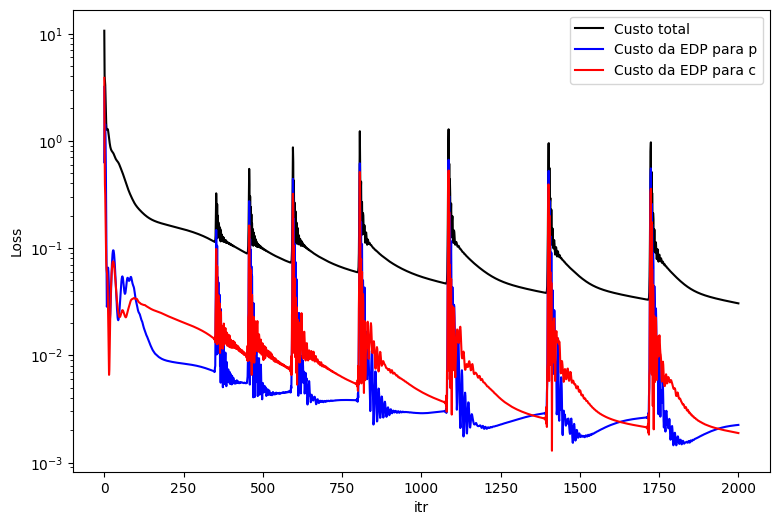

In [65]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(range(len(historico)), historico, 'k-', label='Custo total')
ax.plot(range(len(erro_aux_p)), erro_aux_p, 'b-', label='Custo da EDP para p')
ax.plot(range(len(erro_aux_c)), erro_aux_c, 'r-', label='Custo da EDP para c')
ax.set_yscale('log')
ax.set_xlabel('itr')
ax.set_ylabel('Loss');
ax.legend()
plt.show()

In [66]:
N = 100
xspace = np.linspace(lb[1], ub[1], N + 1)
yspace = np.linspace(lb[2], ub[2], N + 1)

#em t = 0.1
t_01 = 0.1
T, X, Y = np.meshgrid(t_01, xspace, yspace)
X01 = np.vstack([T.flatten(),X.flatten(), Y.flatten()]).T
u = modelo(X01)
p_01, c_01 = u[:, 0:1].numpy().reshape(1, N+1, N+1), u[:, 1:2].numpy().reshape(1, N+1, N+1)

#em t = 0.5s
t_05 = 0.5
T, X, Y = np.meshgrid(t_05, xspace, yspace)
X05 = np.vstack([T.flatten(),X.flatten(), Y.flatten()]).T
u_05 = modelo(X05)
p_05, c_05 = u_05[:, 0:1].numpy().reshape(1, N+1, N+1), u_05[:, 1:2].numpy().reshape(1, N+1, N+1)

#em t=1s
t_1 = 1.0
T,X,Y = np.meshgrid(t_1, xspace, yspace)
X1 = np.vstack([T.flatten(), X.flatten(), Y.flatten()]).T
u_1 = modelo(X1)
p_1, c_1 = u_1[:, 0:1].numpy().reshape(1, N+1, N+1), u_1[:, 1:2].numpy().reshape(1, N+1, N+1)

Xaux, Yaux = np.meshgrid(xspace, yspace)

Text(0.5, 0.92, 'Solução para c = c(t + x + y) em t = 1')

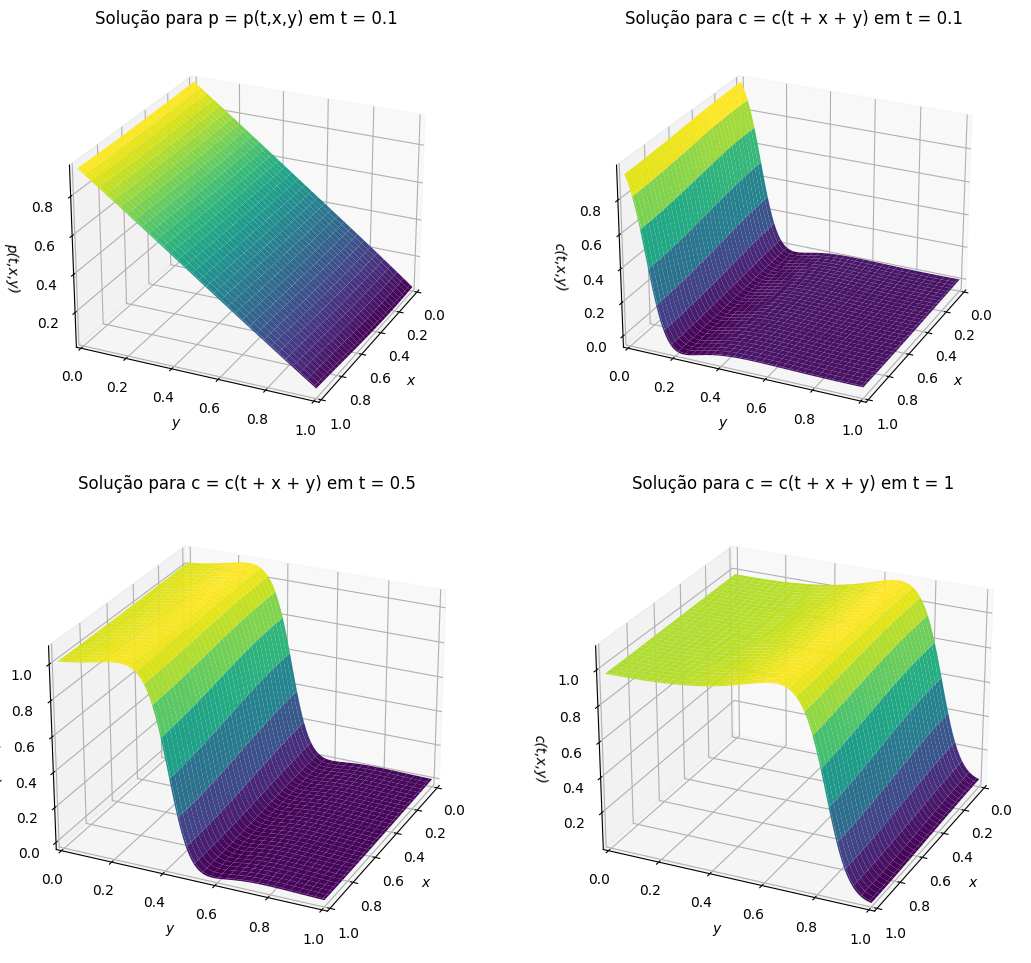

In [67]:
fig  = plt.figure(figsize = (20, 18))
# snapshot 1
ax   = fig.add_subplot(3, 3, 1, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, p_01[0], cmap = "viridis")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.view_init(25,25)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('p(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para p = p(t,x,y) em t = 0.1')

ax   = fig.add_subplot(3, 3, 2, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, c_01[0], cmap = "viridis")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.view_init(25,25)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('c(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para c = c(t + x + y) em t = 0.1')
# snapshot 2
ax   = fig.add_subplot(1, 3, 1, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, c_05[0], cmap = "viridis")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.view_init(25,25)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('c(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para c = c(t + x + y) em t = 0.5')
# snapshot 3
ax   = fig.add_subplot(1, 3, 2, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, c_1[0], cmap = "viridis")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.view_init(25,25)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('c(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para c = c(t + x + y) em t = 1')

In [68]:
tspace = np.linspace(lb[0], ub[0], N + 1)
Tt, Xt, Yt = np.meshgrid(tspace, xspace, yspace)
Xgrid = np.vstack([Tt.flatten(),Xt.flatten(), Yt.flatten()]).T

#Realizando predição
upred = modelo(Xgrid)
c = upred[:,1:2]

In [69]:
C = c.numpy().reshape(N+1,N+1,N+1)

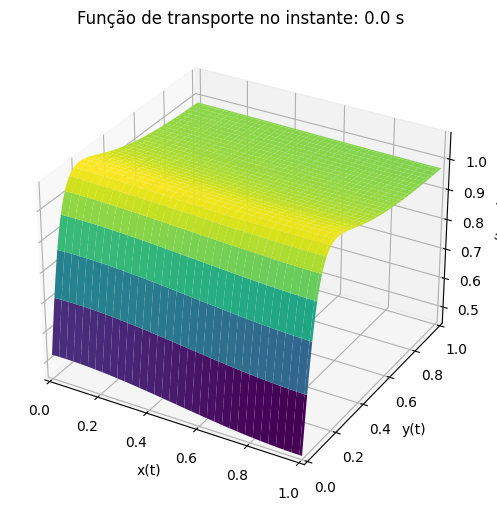

In [70]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

def frame(w):
    ax.clear()

    plt.title("Função de transporte no instante: {:1.4} s".format(tspace[w]))
    ax.set_xlabel('x(t)')
    ax.set_xlim3d(0,1)
    ax.set_ylabel('y(t)')
    ax.set_ylim3d(0,1)
    ax.set_zlabel('c(t,x,y)'.format(tspace[w]))
    #ax.set_zlim3d(-val1,val1)

    plot=ax.plot_surface(Xaux, Yaux, C[-w], cmap='viridis')


    return plot


anim = animation.FuncAnimation(fig, frame, frames=100, blit=False, repeat=True)

anim.save('Função Transporte PINN.gif', writer = "pillow", fps=10 )
HTML(anim.to_html5_video())

In [13]:
class PINN_Arquitetura(keras.Model):

    def __init__(self, lb, ub,
            saida=2,
            camadas_ocultas=8,
            nos_ocultos=20,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.camadas_ocultas = camadas_ocultas
        self.saida = saida
        self.lb = lb
        self.ub = ub


        self.scale = keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
        self.hidden = [Dense(nos_ocultos,
                             activation=keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.camadas_ocultas)]
        self.out = Dense(saida)

    def call(self, X):

        Z = self.scale(X)
        for i in range(self.camadas_ocultas):
            Z = self.hidden[i](Z)
        return self.out(Z)

In [14]:
modelo = PINN_Arquitetura(lb, ub)
modelo.build(input_shape = (None, 3))
modelo.summary()

Model: "pinn__arquitetura_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  80        
                                                                 
 dense_10 (Dense)            multiple                  420       
                                                                 
 dense_11 (Dense)            multiple                  420       
                                                                 
 dense_12 (Dense)            multiple                  420       
                                                                 
 dense_13 (Dense)            multiple                  420       
                                                                 
 dense_14 (Dense)            multiple          

In [15]:
class PINN():
    def __init__(self, modelo, espacor, espaco0, c0, espacobx1, p_contx1, c_contx1, espacobx2, p_contx2, espacoby1, espacoby2):
        self.modelo = modelo

        #pontos de colocação da edp
        self.t = espacor[:,0:1]
        self.x = espacor[:,1:2]
        self.y = espacor[:,2:3]
        self.t0 = espaco0[:,0:1]; self.x0 = espaco0[:,1:2]; self.y0 = espaco0[:,2:3]
        self.tx1 = espacobx1[:,0:1]; self.xx1 = espacobx1[:,1:2]; self.yx1 = espacobx1[:,2:3]
        self.tx2 = espacobx2[:,0:1]; self.xx2 = espacobx2[:,1:2]; self.yx2 = espacobx2[:,2:3]
        self.ty1 = espacoby1[:,0:1]; self.xy1 = espacoby1[:,1:2]; self.yy1 = espacoby1[:,2:3]
        self.ty2 = espacoby2[:,0:1]; self.xy2 = espacoby2[:,1:2]; self.yy2 = espacoby2[:,2:3]

        self.espacobx1 = espacobx1
        self.espacobx2 = espacobx2
        self.espacoby1 = espacoby1
        self.espacoby2 = espacoby2

        self.c0 = c0
        self.p_contx1 = p_contx1
        self.c_contx1 = c_contx1
        self.p_contx2 = p_contx2

        #histórico de perdas e o contador global de iterações
        self.hist = []
        self.hist_p = []
        self.hist_c = []
        self.iter = 0

    def gradiente(self):
      #Registrando tempo e posição para a diferenciação automática

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(self.t)
            tape.watch(self.x)
            tape.watch(self.y)

            #previsão do modelo
            u = self.modelo(tf.concat([self.t, self.x, self.y], axis = 1))
            p, c = u[:, 0:1], u[:, 1:2]
            #edp para pressão
            f = -( tape.gradient(tape.gradient(p, self.x), self.x) + tape.gradient(tape.gradient(p, self.y), self.y))
            v1 = -tape.gradient(p,self.x)
            v2 = -tape.gradient(p,self.y)
            g = tape.gradient(c,self.t) - tape.gradient(v1*c, self.x) - tape.gradient(v2*c , self.y)
            #edo para função de transporte
            #g = tape.gradient(c,self.t) + tape.gradient(f*c, self.x) + tape.gradient(f*c , self.y)

        del tape

        return f, g

    def neumanncondy1(self):
      with tf.GradientTape(persistent=True) as tape:
        tape.watch(self.ty1)
        tape.watch(self.xy1)
        tape.watch(self.yy1)

        uy1 = self.modelo(tf.concat([self.ty1, self.xy1, self.yy1], axis = 1))

        p_y1, c_y1 = uy1[:,0:1], uy1[:,1:2]
        c_y = tape.gradient(c_y1, self.yy1)
        p_y = tape.gradient(p_y1, self.yy1)

        return p_y, c_y

    def neumanncondx2(self):
      with tf.GradientTape(persistent=True) as tape:
        tape.watch(self.tx2)
        tape.watch(self.xx2)
        tape.watch(self.yx2)

        ux2 = self.modelo(tf.concat([self.tx2, self.xx2, self.yx2], axis = 1))

        p_x2, c_x2 = ux2[:,0:1], ux2[:,1:2]
        c_x = tape.gradient(c_x2, self.xx2)


        return p_x2, c_x

    def neumanncondy2(self):
      with tf.GradientTape(persistent=True) as tape:
        tape.watch(self.ty2)
        tape.watch(self.xy2)
        tape.watch(self.yy2)

        uy2 = self.modelo(tf.concat([self.ty2, self.xy2, self.yy2], axis = 1))

        p_y2, c_y2 = uy2[:,0:1], uy2[:,1:2]
        c_y = tape.gradient(c_y2, self.yy2)
        p_y = tape.gradient(p_y2, self.yy2)


        return p_y, c_y


    def MSE(self, espacor, espaco0, c0, espacobx1, p_contx1, c_contx1, espacobx2, p_contx2, espacoby1, espacoby2):
      #Erro edp
        f, g = self.gradiente()
        erro_p = tf.reduce_mean(tf.square(f))
        erro_c = tf.reduce_mean(tf.square(g))

        loss = erro_p + erro_c
        #Erro da rede neural
        u0 = self.modelo(espaco0)
        c0pred = u0[:,1:2]
        ux1 = self.modelo(espacobx1)
        p_x1, c_x1 = ux1[:,0:1], ux1[:,1:2]
        p_pred, c_x2 = self.neumanncondx2()
        p_y1, c_y1 = self.neumanncondy1()
        p_y2, c_y2 = self.neumanncondy2()

        loss += tf.reduce_mean(tf.square(p_contx1 - p_x1)) + tf.reduce_mean(tf.square(c_contx1 - c_x1)) + tf.reduce_mean(tf.square(p_contx2 - p_pred))
        loss += tf.reduce_mean(tf.square(c_x2)) + tf.reduce_mean(tf.square(c_y2)) + tf.reduce_mean(tf.square(c_y1)) + tf.reduce_mean(tf.square(p_y2)) + tf.reduce_mean(tf.square(p_y1))

        return erro_p, erro_c, loss

    def grad(self, espacor, espaco0, c0, espacobx1, p_contx1, c_contx1, espacobx2, p_contx2, espacoby1, espacoby2):
      #tirando o gradiente em relação ao modelos, para que eles sejam atualizados posteriormente
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.modelo.trainable_variables)
            erro_p, erro_c, loss = self.MSE(espacor, espaco0, c0, espacobx1, p_contx1, c_contx1, espacobx2, p_contx2, espacoby1, espacoby2)

        g = tape.gradient(loss, self.modelo.trainable_variables)
        del tape

        return erro_p, erro_c, loss, g


    def treino(self, espacor, espaco0, c0, espacobx1, p_contx1, c_contx1, espacobx2, p_contx2, espacoby1, espacoby2, method='L-BFGS-B', **kwargs):

        def get_weight_tensor():
            #Função para retornar variáveis atuais do modelo como tensor 1d, bem como formas correspondentes como listas.

            weight_list = []
            shape_list = []

            #loop sobre todas as variáveis, ou seja, matrizes de peso + bias e parâmetros desconhecidos
            for v in self.modelo.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            #Função que define lista de pesos para variáveis do modelo.
            idx = 0
            for v in self.modelo.variables:
                vs = v.shape

                #Matriz do peso
                if len(vs) == 2:
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw

                #Vetor bias
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]

                #Variáveis (no caso de configuração de identificação de parâmetro)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1

                #Atribuir variáveis (cast necessário, pois o scipy requer o tipo float64)
                v.assign(tf.cast(new_val, 'float32'))

        def get_loss_and_grad(w):
            #Função que fornece perda de custo e gradiente em relação às variáveis ​​treináveis ​​como vetor.

            #Atualizar os pesos
            set_weight_tensor(w)
            #Determinar o custo da rede neural
            erro_p, erro_c, loss, grad = self.grad(espacor, espaco0, c0, espacobx1, p_contx1, c_contx1, espacobx2, p_contx2, espacoby1, espacoby2)

            #Armazenando o custo atual para a função de retorno
            loss = loss.numpy().astype(np.float64)
            erro_p = erro_p.numpy().astype(np.float64)
            erro_c = erro_c.numpy().astype(np.float64)
            self.current_loss = loss
            self.current_erro_p = erro_p
            self.current_erro_c = erro_c

            #Salvando os valores do gradiente
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())

            #Convertendo para array
            grad_flat = np.array(grad_flat,dtype=np.float64)

            #Retornando o custo e o gradiente
            return loss, grad_flat

        #retorno, minimizando o gradiente
        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: Loss = {:10.8e}, Loss edp f = {:10.8e}, Loss edp g = {:10.8e}'.format(self.iter,self.current_loss, self.current_erro_p, self.current_erro_c))
        self.hist.append(self.current_loss)
        self.hist_p.append(self.current_erro_p)
        self.hist_c.append(self.current_erro_c)
        self.iter+=1


    def plot_momentos(self, **kwargs):
      N = 100
      xspace = np.linspace(self.modelo.lb[1], self.modelo.ub[1], N+1)
      yspace = np.linspace(self.modelo.lb[2], self.modelo.ub[2], N+1)
      xplot, yplot = np.meshgrid(xspace, yspace)


      t_01 = 0.1
      t_05 = 0.5
      t_1 = 1
      T_01, x01, y01 = np.meshgrid(t_01, xspace, yspace); T_05, x05, y05 = np.meshgrid(t_05, xspace, yspace); T_1, x1, y1 = np.meshgrid(t_1, xspace, yspace)
      X01 = np.vstack([T_01.flatten(),x01.flatten(), y01.flatten()]).T
      X05 = np.vstack([T_05.flatten(), x05.flatten(), y05.flatten()]).T
      X1 = np.vstack([T_1.flatten(), x1.flatten(), y1.flatten()]).T

      #Realizando predição
      upred01 = self.modelo(tf.cast(X01,'float32'))
      p_01, c_01 = upred01[:, 0:1].numpy().reshape(1, N+1, N+1), upred01[:, 1:2].numpy().reshape(1, N+1, N+1)

      upred05 = self.modelo(tf.cast(X05, 'float32'))
      p_05, c_05 = upred05[:, 0:1].numpy().reshape(1, N+1, N+1), upred05[:, 1:2].numpy().reshape(1, N+1, N+1)

      upred1 = self.modelo(tf.cast(X1, 'float32'))
      p_1, c_1 = upred1[:, 0:1].numpy().reshape(1, N+1, N+1), upred1[:, 1:2].numpy().reshape(1, N+1, N+1)

      fig  = plt.figure(figsize = (20, 18))
      # snapshot 1
      ax   = fig.add_subplot(3, 3, 1, projection = "3d")
      surf = ax.plot_surface(xplot, yplot, p_01[0], cmap = "jet")
      ax.set_xlim(xmin, xmax)
      ax.set_ylim(ymin, ymax)
      ax.set_xlabel("x", fontstyle = "italic")
      ax.set_ylabel("y", fontstyle = "italic")
      ax.set_zlabel('p(t,x,y)', fontstyle = "italic")
      ax.set_title('Solução para p = cos(0.1 + x + y)')

      ax   = fig.add_subplot(3, 3, 2, projection = "3d")
      surf = ax.plot_surface(xplot, yplot, c_01[0], cmap = "jet")
      ax.set_xlim(xmin, xmax)
      ax.set_ylim(ymin, ymax)
      ax.set_xlabel("x", fontstyle = "italic")
      ax.set_ylabel("y", fontstyle = "italic")
      ax.set_zlabel('c(t,x,y)', fontstyle = "italic")
      ax.set_title('Solução para c = sin(0.1 + x + y)')
      # snapshot 2
      ax   = fig.add_subplot(1, 3, 1, projection = "3d")
      surf = ax.plot_surface(xplot, yplot, c_05[0], cmap = "jet")
      ax.set_xlim(xmin, xmax)
      ax.set_ylim(ymin, ymax)
      ax.set_xlabel("x", fontstyle = "italic")
      ax.set_ylabel("y", fontstyle = "italic")
      ax.set_zlabel('c(t,x,y)', fontstyle = "italic")
      ax.set_title('Solução para c = sin(0.5 + x + y)')
      # snapshot 3
      ax   = fig.add_subplot(1, 3, 2, projection = "3d")
      surf = ax.plot_surface(xplot, yplot, c_1[0], cmap = "jet")
      ax.set_xlim(xmin, xmax)
      ax.set_ylim(ymin, ymax)
      ax.set_xlabel("x", fontstyle = "italic")
      ax.set_ylabel("y", fontstyle = "italic")
      ax.set_zlabel('c(t,x,y)', fontstyle = "italic")
      ax.set_title('Solução para c = sin(1 + x + y)')
      return ax

    def plot_loss_history(self, ax= None):
        if not ax:
            fig = plt.figure(figsize=(9,6))
            ax = fig.add_subplot(111)
        ax.plot(range(len(self.hist)), self.hist, 'k-', label = 'Custo total')
        ax.plot(range(len(self.hist_p)), self.hist_p, 'b-', label  = 'Custo associado a EDP f')
        ax.plot(range(len(self.hist_c)), self.hist_c, 'r-', label  = 'Custo associado a EDP g')
        ax.set_yscale('log')
        ax.set_xlabel('itr')
        ax.set_ylabel('Loss')
        ax.legend()
        return ax

In [16]:
modelo_pinn = PINN(modelo, espacor, espaco0, c0, espacobx1, p_contx1, c_contx1, espacobx2, p_contx2, espacoby1, espacoby2)

t0 = time()
modelo_pinn.treino(espacor, espaco0, c0, espacobx1, p_contx1, c_contx1, espacobx2, p_contx2, espacoby1, espacoby2,
                            method='L-BFGS-B',
                            options={'maxiter': 50000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})

print('\nTempo de treino da rede neural: {} segundos'.format(time()-t0))

It 00000: Loss = 3.35215020e+00, Loss edp f = 1.39141130e+00, Loss edp g = 5.00302970e-01
It 00050: Loss = 1.02978083e-03, Loss edp f = 2.21893948e-04, Loss edp g = 2.18906818e-04
It 00100: Loss = 5.54651779e-05, Loss edp f = 1.72746622e-05, Loss edp g = 1.26573950e-05
It 00150: Loss = 1.20548793e-05, Loss edp f = 3.04898913e-06, Loss edp g = 3.12550560e-06
It 00200: Loss = 4.07219341e-06, Loss edp f = 1.02702052e-06, Loss edp g = 1.07480355e-06
It 00250: Loss = 2.82265864e-06, Loss edp f = 6.48635137e-07, Loss edp g = 6.92074480e-07
It 00300: Loss = 2.30050387e-06, Loss edp f = 5.88868659e-07, Loss edp g = 5.89559704e-07
It 00350: Loss = 1.74278921e-06, Loss edp f = 5.29482350e-07, Loss edp g = 5.15099316e-07
It 00400: Loss = 1.06903076e-06, Loss edp f = 2.78648713e-07, Loss edp g = 2.79322222e-07
It 00450: Loss = 8.95734388e-07, Loss edp f = 2.55534559e-07, Loss edp g = 2.57935596e-07
It 00500: Loss = 6.52350820e-07, Loss edp f = 1.94061940e-07, Loss edp g = 2.07293908e-07
It 00550: 

<Axes3D: title={'center': 'Solução para c = sin(1 + x + y)'}, xlabel='x', ylabel='y', zlabel='c(t,x,y)'>

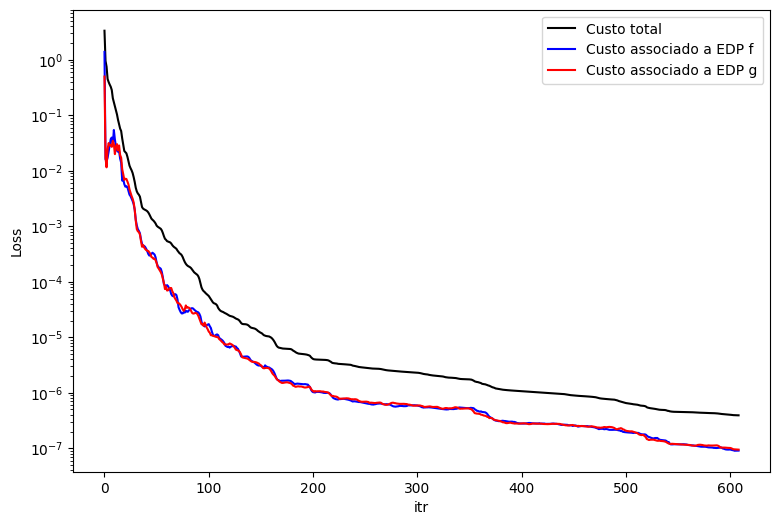

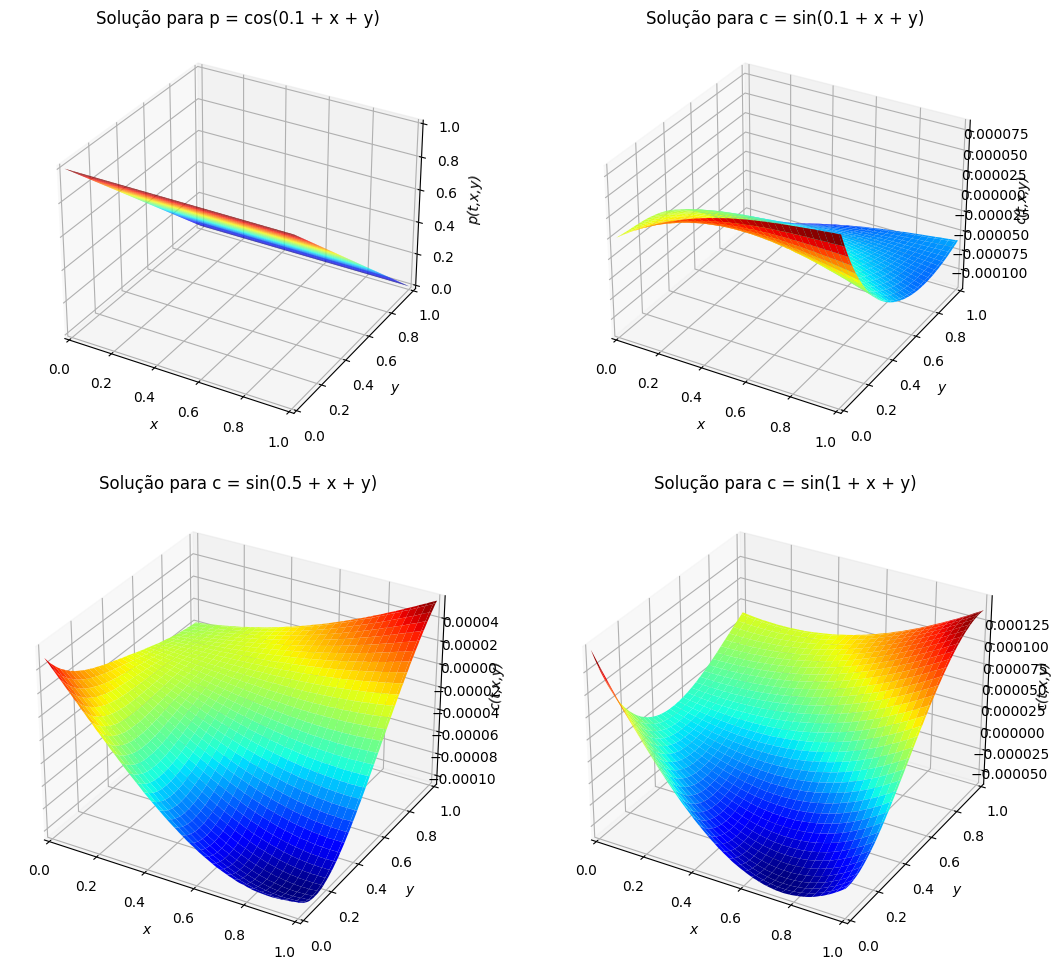

In [17]:
modelo_pinn.plot_loss_history();
modelo_pinn.plot_momentos()